## Calls

In [1]:
from pymongo import MongoClient

import time

# if jupyter runs on localhost
# MONGO_HOST="localhost"

# if jupyter runs in docker
MONGO_HOST="host.docker.internal"

MONGO_USER="root"
MONGO_PASSWORD="password"
MONGO_PORT=27017

address = 'mongodb://{user}:{password}@{host}:{port}'.format(
    user= MONGO_USER,
    password= MONGO_PASSWORD,
    host= MONGO_HOST,
    port= MONGO_PORT,
)

client = MongoClient(address)
database=client["observertc-reports"]

# the collection we want to query
reportsDatabase = database.reports

# print('connected to %s' % address)

cursor = reportsDatabase.find( { "type": "CALL_EVENT", "payload.name": { "$in": ["CLIENT_JOINED", "CLIENT_LEFT"] } } )

rooms = {}
for record in cursor:
    callEvent = record["payload"]

    roomId = callEvent["roomId"]
    callId = callEvent["callId"]
    userId = callEvent['userId']
    clientId = callEvent['clientId']
    timestamp = callEvent['timestamp']

    calls = rooms.get(roomId, {})
    clients = calls.get(callId, {})
    client = clients.get(clientId, {
        "clientId": clientId,
        "userId": userId,
        "callId": callId,
        "roomId": roomId,
    })
    
    if callEvent["name"] == "CLIENT_JOINED":
        client.update({ "joined": timestamp })
    else:
        client.update({ "left": timestamp })
    
    clients[clientId] = client
    calls[callId] = clients
    rooms[roomId] = calls

for room in rooms.items():
    roomId, calls = room
    print('\nRoom: %s\n--------' % roomId)
    for call in calls.items():
        callId, clients = call
        print('\nCall %s' % callId)
        for client in clients.values():
            userId, clientId, joined = client["userId"], client["clientId"], client["joined"]
            left = client.get("left", int(time.time() * 1000))
            duration = (left - joined) / (60 * 1000)
            print('\n\tUserId: %s \n\tClientId: %s\n\tJoined: %d\n\tLeft: %d\n\tDuration: %d min' % 
                  (userId, clientId, joined, left, duration))


Room: Pyongyang
--------

Call 9236312f-2697-41e4-82d4-3ff43fd404e8

	UserId: Dumbledore 
	ClientId: 8b2a6420-b596-4005-aabf-e849a992502d
	Joined: 1657197987140
	Left: 1657197993061
	Duration: 0 min

	UserId: Fleur Delacour 
	ClientId: 806b77ce-a81c-4e05-9b50-956ec618d442
	Joined: 1657197994033
	Left: 1657197998063
	Duration: 0 min

Room: Kabul
--------

Call cf400eb5-d979-4441-a056-b7e98e64d9f3

	UserId: McGonagall 
	ClientId: c2a49398-efb0-4ebe-b97f-b96b58aede93
	Joined: 1657199265848
	Left: 1657204468216
	Duration: 86 min

	UserId: Snape 
	ClientId: 3b26fb8c-80c6-4910-8f78-ddea858d6a59
	Joined: 1657199277467
	Left: 1657204468216
	Duration: 86 min

Room: Cairo
--------

Call 85987ce6-817d-4831-bb48-6e8f4762fed9

	UserId: Ron Weasely 
	ClientId: 1aece275-7992-4d0d-9537-3791f29d61b2
	Joined: 1657204303021
	Left: 1657204468216
	Duration: 2 min

	UserId: Ginny 
	ClientId: 468c9502-619f-48de-a89a-5043d6f6a08d
	Joined: 1657204320108
	Left: 1657204468216
	Duration: 2 min

Room: Caracas
---

## Select the call and the client we want to plot the end-to-end RTTs

In [2]:
CALL_ID = "635e0c58-b6da-4f9d-b3c2-ff6fe458df60"
CLIENT_ID = "50c62bc3-7c52-4af2-b271-1352fac03f65"

print("selected call:", CALL_ID, "sleected client:", CLIENT_ID)



selected call: 635e0c58-b6da-4f9d-b3c2-ff6fe458df60 sleected client: 50c62bc3-7c52-4af2-b271-1352fac03f65


### Collect peer connections RTT measurements

In [3]:
peer_connection_rtts = {}

stage_match = {
    "$match": {
        "$or": [{ "type": "OUTBOUND_VIDEO_TRACK" }, { "type": "OUTBOUND_AUDIO_TRACK" }], 
        "payload.callId": CALL_ID,
   }
}

pipeline = [
   stage_match, 
]

cursor = reportsDatabase.aggregate(pipeline)
for report in cursor:
    payload = report["payload"]
    peerconnection_id = payload["peerConnectionId"]
    rtt_in_s = payload["roundTripTime"]
    timestamp = payload["timestamp"]
    
    measurements = peer_connection_rtts.get(peerconnection_id, [])
    measurement = (rtt_in_s, timestamp)
    measurements.append(measurement)
    peer_connection_rtts[peerconnection_id] = measurements
    
# data check
for peerconnection_id in peer_connection_rtts:
    print("Number of measurements to analyze on %s: %s" % (peerconnection_id, len(peer_connection_rtts[peerconnection_id])))
 

Number of measurements to analyze on 2016e451-262d-4714-aea3-fe512d77aca7: 26
Number of measurements to analyze on c779e802-539d-4dfd-9176-127f354d9827: 26


### Collect Client peer connections

In [4]:
# map client ids to its peer connections subscribed to receive inbound tracks
client_inb_pc_ids = {}

# peer connections to its remote peer connections and clients
inb_pc_outb_pairs = {}

# have an inner map for every client map remote client to the peer connection sending outbound tracks
client_outb_pc_pairs = {}

# the sfu map of sink id to stream id the selected client uses to 
# receive RTP sessions from the SFU it is connected to.
sfu_sink_to_stream_ids = {}

# pc to to sfu sink ids
pc_to_sfu_sink_ids = {}

stage_match = {
    "$match": {
        "$or": [{ "type": "INBOUND_VIDEO_TRACK" }, { "type": "INBOUND_AUDIO_TRACK" }],
        "payload.callId": CALL_ID,
   }
}
pipeline = [
   stage_match,
]

cursor = reportsDatabase.aggregate(pipeline)
for report in cursor:
    payload = report["payload"]
    client_id = payload["clientId"]
    client_peerconnection_id = payload["peerConnectionId"]
    sfu_sink_id = payload["sfuSinkId"]
    sfu_stream_id = payload["sfuStreamId"]
    remote_client_id = payload["remoteClientId"]
    remote_client_peerconnection_id = payload["remotePeerConnectionId"]

    sfu_sink_to_stream_ids[sfu_sink_id] = sfu_stream_id
    
    if client_peerconnection_id is None:
        continue
    
    sfu_sink_ids = pc_to_sfu_sink_ids.get(client_peerconnection_id, set())
    sfu_sink_ids.add(sfu_sink_id)
    pc_to_sfu_sink_ids[client_peerconnection_id] = sfu_sink_ids
    
    inb_pc_ids = client_inb_pc_ids.get(client_id, set())
    inb_pc_ids.add(client_peerconnection_id)
    client_inb_pc_ids[client_id] = inb_pc_ids

    if remote_client_id is not None and remote_client_peerconnection_id is not None:
        inb_pc_outb_pairs[client_peerconnection_id] = (remote_client_peerconnection_id, remote_client_id)

        client_remote_peers = client_outb_pc_pairs.get(remote_client_id, {})
        client_remote_peers[client_id] = remote_client_peerconnection_id
        client_outb_pc_pairs[client_id] = client_remote_peers

# data check
for client_id in client_outb_pc_pairs:
    print("client_id:%s  maps to the following remote_peer_ids: %s" % (client_id, client_outb_pc_pairs[client_id]))


client_id:b314af08-642c-4896-af4b-6bd9ce530038  maps to the following remote_peer_ids: {'b314af08-642c-4896-af4b-6bd9ce530038': '2016e451-262d-4714-aea3-fe512d77aca7', '50c62bc3-7c52-4af2-b271-1352fac03f65': 'c779e802-539d-4dfd-9176-127f354d9827'}
client_id:50c62bc3-7c52-4af2-b271-1352fac03f65  maps to the following remote_peer_ids: {'b314af08-642c-4896-af4b-6bd9ce530038': '2016e451-262d-4714-aea3-fe512d77aca7', '50c62bc3-7c52-4af2-b271-1352fac03f65': 'c779e802-539d-4dfd-9176-127f354d9827'}


### Collect SFU Transport RTT measurements

In [5]:
sfu_sink_to_stream_ids
sfu_sink_ids = list(sfu_sink_to_stream_ids.keys())
sfu_stream_ids = list(sfu_sink_to_stream_ids.values())

In [7]:
sfu_sink_to_sfu = {}
sfu_transport_rtts = {}
transports_to_sfu = {}

stage_match = {
    "$match": {
        "type": "SFU_OUTBOUND_RTP_PAD", 
#         "payload.sfuStreamId": { "$in": sfu_stream_ids},
#         "payload.sfuSinkId": { "$in": list(sfu_sink_to_stream_ids.keys())},
#         "payload.internal": True,
   }
}

pipeline = [
   stage_match, 
]

cursor = reportsDatabase.aggregate(pipeline)
for report in cursor:
    payload = report["payload"]
    sfu_id = payload["sfuId"]
    sfu_sink_id = payload["sfuSinkId"]
    sfu_transport_id = payload["transportId"]
    rtt_in_ms = payload["roundTripTime"]
    timestamp = payload["timestamp"]
    internal = payload["internal"]

    if rtt_in_ms is None:
        continue
        
    if internal is None or internal is False:
        sfu_sink_to_sfu[sfu_sink_id] = sfu_id
        continue
    
    transports_to_sfu[sfu_transport_id] = sfu_id
    
    measurements = sfu_transport_rtts.get(sfu_transport_id, [])
    measurement = (rtt_in_ms / 1000, timestamp)
    measurements.append(measurement)
    sfu_transport_rtts[sfu_transport_id] = measurements
    
print("mapping transport ids to sfu ids:", transports_to_sfu)
print("mapping sfu sinks to sfus:", sfu_sink_to_sfu)


mapping transport ids to sfu ids: {'6254261b-2098-43b6-a5ec-573486cba05b': '1124de3b-fc2d-430f-87bd-5bfc8098fcab', '3d9ca887-1004-4537-8632-bd781de03a89': 'ab9a5927-e9b9-463e-b6f7-4ca2b8e5955b'}
mapping sfu sinks to sfus: {'03368097-9976-4ccc-9094-34191784b4a5': '9aa7bc11-cbc0-490d-aa70-e7bea8d83041', '63856c04-9c2f-4c90-9ee2-9f577dafffad': '9aa7bc11-cbc0-490d-aa70-e7bea8d83041', 'd7fd8e69-9e50-436a-89e4-37686652a17e': '9aa7bc11-cbc0-490d-aa70-e7bea8d83041', '424139ab-4783-4606-b484-58f9fd49b95b': '9aa7bc11-cbc0-490d-aa70-e7bea8d83041', '651dc19b-06ff-464f-a184-869a2c6c11f7': '1124de3b-fc2d-430f-87bd-5bfc8098fcab', '7dd79e91-dd38-486d-8971-fe48eb39a11d': '1124de3b-fc2d-430f-87bd-5bfc8098fcab', 'c7aece50-6c74-4e9f-a453-1b9c6c677c17': 'ab9a5927-e9b9-463e-b6f7-4ca2b8e5955b', '5009078b-6d5f-42e7-a1e1-8aec6bca170f': 'ab9a5927-e9b9-463e-b6f7-4ca2b8e5955b'}


### Collect SFU transports

In [9]:
transport_pairs = {}

stage_match = {
    "$match": {
        "type": "SFU_INBOUND_RTP_PAD",
        "payload.sfuStreamId": { "$in": sfu_stream_ids },
        "payload.internal": True,
   }
}
pipeline = [
   stage_match,
]

cursor = reportsDatabase.aggregate(pipeline)
for report in cursor:
    internal = payload["internal"]
    payload = report["payload"]
    sfu_id = payload["sfuId"]
    sfu_transport_id = payload["transportId"]
    remote_sfu_transport_id = payload["remoteTransportId"]
    
    
    if remote_sfu_transport_id is not None:
        transport_pairs[sfu_transport_id] = remote_sfu_transport_id
    
print("internal transport mappings:", transport_pairs)

internal transport mappings: {'6254261b-2098-43b6-a5ec-573486cba05b': '3d9ca887-1004-4537-8632-bd781de03a89', '3d9ca887-1004-4537-8632-bd781de03a89': '6254261b-2098-43b6-a5ec-573486cba05b'}


### Calculate Client end-to-end RTTs

In [10]:
client_to_client_rtts = {}

for client_inb_pc_id in client_inb_pc_ids[CLIENT_ID]:
    
    remote_pc_id, remote_client_id = inb_pc_outb_pairs[client_inb_pc_id]
    remote_measurements = peer_connection_rtts[remote_pc_id]

    remote_client_peers = client_outb_pc_pairs[remote_client_id]
    client_outb_pc_id = remote_client_peers[CLIENT_ID]
    local_measurements = peer_connection_rtts[client_outb_pc_id]
    
    sfu_sink_ids = pc_to_sfu_sink_ids[client_inb_pc_id]
    sfu_id = None
    for it_sink_id, it_sfu_id in sfu_sink_to_sfu.items():
        if it_sink_id in sfu_sink_ids:
            sfu_id = it_sfu_id
    if sfu_id is None:
        raise Exception("No sfu id found for sfu sink")
    transport_id = None
    for it_transport_id, it_sfu_id in transports_to_sfu.items():
        if sfu_id == it_sfu_id:
            transport_id = it_transport_id
            break
    if transport_id is None:
        raise Exception("No sfu transport id found for sfu id")
        
    transport_rtts = sfu_transport_rtts[transport_id]
    
    sorted_local_measurements = sorted(local_measurements, key=lambda x: x[1])
    sorted_remote_measurements = sorted(remote_measurements, key=lambda x: x[1])
    sorted_transport_rtts = sorted(transport_rtts, key=lambda x: x[1])
    
    i, j, k, loc_size, rem_size, tra_size = 0, 0, 0, \
        len(sorted_local_measurements), len(sorted_remote_measurements), len(sorted_transport_rtts)
    end_to_end_rtts = []
    timestamps = []
    
    while True:
        if loc_size <= i or rem_size <= j or tra_size <= k:
            break
           
        local_client_to_sfu_rtt, local_client_actual_ts = sorted_local_measurements[i]
        remote_client_to_sfu_rtt, remote_client_actual_ts = sorted_remote_measurements[j]
        sfu_to_sfu_rtt, sfu_ts = sorted_transport_rtts[k]

        if  i + 1 < loc_size and ( 
              sorted_local_measurements[i + 1][1] < remote_client_actual_ts or 
              sorted_local_measurements[i + 1][1] < sfu_ts 
        ):
            i = i + 1
            continue
        
        if j + 1 < rem_size and (
            sorted_remote_measurements[j + 1][1] < local_client_actual_ts or
            sorted_remote_measurements[j + 1][1] < sfu_ts
        ):
            j = j + 1
            continue
        
        if k + 1 < tra_size and (
            sorted_transport_rtts[k + 1][1] < local_client_actual_ts or
            sorted_transport_rtts[k + 1][1] < remote_client_actual_ts
        ):
            k = k + 1
            continue
            
        end_to_end_rtt = local_client_to_sfu_rtt + remote_client_to_sfu_rtt + sfu_to_sfu_rtt
        ts = max(local_client_actual_ts, remote_client_actual_ts, sfu_ts)
        
        end_to_end_rtts.append(end_to_end_rtt)
        timestamps.append(ts)
        
        i = i + 1
        j = j + 1
        k = k + 1

    client_to_client_rtts[remote_client_id] = (timestamps, end_to_end_rtts)

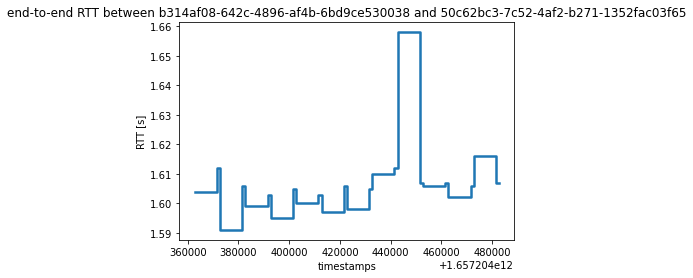

In [11]:
import matplotlib.pyplot as plt

for remote_client_id, remote_client_rtts in client_to_client_rtts.items():
    x, y = remote_client_rtts
    fig, ax = plt.subplots()
    
    remote_client = clients[remote_client_id]
    ax.set_title("end-to-end RTT between " + remote_client_id + " and " + CLIENT_ID)
    ax.step(x, y, linewidth=2.5)
    ax.set_xlabel('timestamps')
    ax.set_ylabel('RTT [s]')
    plt.show()